# Exercise 16.1
## Zachary’s karate club - semi-supervised node classification
In this exercise, we investigate semi-supervised node classification using Graph Convolutional Networks on  Zachary’s Karate Club dataset introduced in Example 10.2.
Sometime ago there was a dispute between the manager and the coach of the karate club which led to a split of the club into four groups.

Can we use Graph Convolutional Networks to predict the affiliation of each member given the social network of the community and the memberships of only four people?

The exercise uses spektral and networkx. If you don't have yet installed both packages, do so by executing:

In [ ]:
import sys
!{sys.executable} -m pip install spektral
!{sys.executable} -m pip install networkx

In [3]:
from tensorflow import keras
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import spektral

print("spektral", spektral.__version__)
print("keras", keras.__version__)

spektral 1.0.6
keras 2.4.0


### Download data: Zachary’s karate club
You can find the original data set [here](http://vlado.fmf.uni-lj.si/pub/networks/data/ucinet/ucidata.htm#zachary).

In [4]:
import gdown
import os
    
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1OugMZz6VVBjWy0uxsG_rrPdrYdPLklzD"
output = 'karate_club.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

f = np.load(output)    
    
adj, features = f["adj"], f["features"]

In [5]:
print("adjacency matrix\n", adj)

adjacency matrix
 [[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [6]:
print("features\n", features)

features
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [7]:
labels_one_hot = f["labels_one_hot"]

def one_hot_to_labels(labels_one_hot):
    return np.sum([(labels_one_hot[:, i] == 1) * (i + 1) for i in range(4)], axis=0)

labels = one_hot_to_labels(labels_one_hot)

print("labels:", labels)

labels: [2 2 3 2 1 1 1 2 4 3 1 2 2 2 4 4 1 2 4 2 4 2 4 4 3 3 4 3 3 4 4 3 4 4]


### Plot data

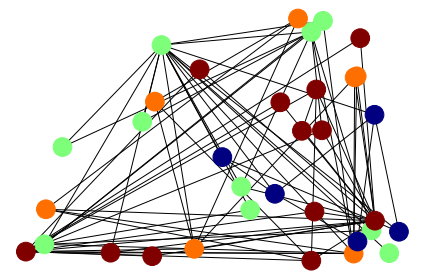

In [8]:
g = nx.from_numpy_matrix(adj)  # define nx graph

fig, _ = plt.subplots(1)
nx.draw(g, pos=nx.random_layout(g), cmap=plt.get_cmap('jet'), node_color=np.log(one_hot_to_labels(labels_one_hot)),
        node_size=np.sum(200 * labels_one_hot, axis=-1) + 150)
plt.tight_layout()

Each node symbolizes one member of the Karate Club, and the edges indicate a close social relationship.
The colors indicate the group affiliation of each member.

We can further make a more sophisticated visualization of the data, by plotting the graph using the `spring_layout`

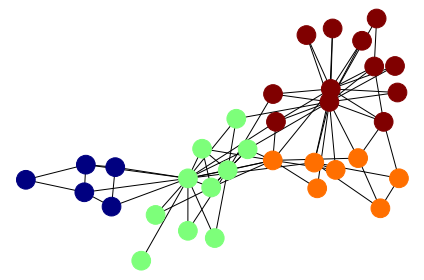

In [9]:
np.random.seed(2)
fig, _ = plt.subplots(1)
nx.draw(g, pos=nx.spring_layout(g), cmap=plt.get_cmap('jet'), node_color=np.log(one_hot_to_labels(labels_one_hot)),
        node_size= np.sum(200 * labels_one_hot, axis=-1) + 150)
plt.tight_layout()

### Preparation of data
In the following, we prepare our data. Let us assume that after the splitting of the karate club, we only have information from 4 members. In this case, each member is part of another group.

This will give us a nice example for a weakly supervised learning task. 

In [10]:
np.random.seed(2)

# Pick randomly one karate fighter from each class
labels_to_keep = np.array([np.random.choice(np.nonzero(labels_one_hot[:, c])[0]) for c in range(4)])
mask = np.zeros(shape=labels_one_hot.shape[0], dtype=np.bool)
mask[labels_to_keep] = ~mask[labels_to_keep]


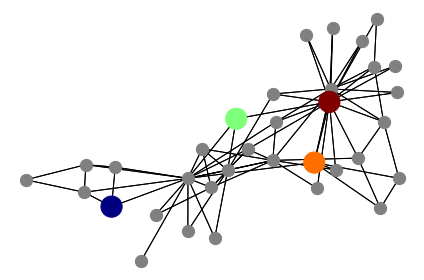

In [11]:
np.random.seed(2)
fig, axes = plt.subplots(1)
nx.draw(g, cmap=plt.get_cmap('jet'), node_color="grey",
        node_size=150)

np.seterr(divide = 'ignore') 
np.random.seed(2)
nx.draw(g, cmap=plt.get_cmap('jet'), node_color=np.log(one_hot_to_labels(labels_one_hot * mask[:,np.newaxis])),
        node_size=450, ax=axes)
np.seterr(divide = 'warn')
plt.tight_layout()

These data we will now use for performing semi-supervised node classification using graph convolutional networks.

### Model definition

In the following we preprocess the data and create a [Graph Convolutional Network](https://arxiv.org/abs/1609.02907) to classify the nodes of the graph (determine the membership of each karate fighter). For more details see Sec.10.4.1 of the book.

Additionally, we create a mask for masking the memberships of all karate fighter except the four members (`labels_to_keep`) when training the GCN.

#### Task 1: Create a meaningful training and validation mask

In [ ]:
train_mask = np.zeros(shape=labels_one_hot.shape[0])
val_mask = np.zeros(shape=labels_one_hot.shape[0])

print("val_mask:\n", val_mask)
print("\ntrain_mask:\n", train_mask)

In [ ]:
# Preprocessing and preparing of data
y_train = labels_one_hot * train_mask[..., np.newaxis]
y_val = labels_one_hot * val_mask[..., np.newaxis]

fltr = spektral.layers.GCNConv.preprocess(adj).astype('f4')  # normalize the adjacency matrix (See Sec.10.4.1)
X = np.identity(34)  # create input for the DNN (the existence of each person (one-hot encoded))

To add a GCN layer to the model use `spektral.layers.GCNConv()[feature_input, adjacency]`, where `feature_input` denotes the input features and `adjacency` the normalized (pre-processed) adjacency matrix ($\hat{A}$).  
Note that the adjacency matrix has to be passed to each GCN layer.

In [ ]:
F = 2  # number of features
N = adj.shape[0]  # number of nodes

X_in = keras.layers.Input(shape=(N,))
fltr_in = keras.layers.Input(shape=(N,))
x = spektral.layers.GCNConv(F, activation='tanh', use_bias=False)([X_in, fltr_in])
x = spektral.layers.GCNConv(F, activation='tanh', use_bias=False)([x, fltr_in])

output = ....

model = keras.models.Model(inputs=[X_in, fltr_in], outputs=output)

print(model.summary())

### Semi-supervised training of the GCN

For training the model, you can make use of the code skeletons below.
To mask during training the DNN predictions for nodes for which labels are not known masking must be applied. This will guarantee that only the predictions made for the four nodes contribute to the objective.

For implementing this condition to perform semi-supervised node classification, you can make use of the `sample_weight` argument of `model.train_on_batch()`.

Note that in this exercise, in contrast to most other exercises, we have to train the network on a single data structure (an undirected graph). Thus, the input data are always `[X, fltr]`, and the targets are `labels_one_hot`.

In [ ]:
learning_rate = 0.01  # this is a reasonable learning rate to start with
epochs = 100


model.compile(...)

In [ ]:
history = []

for i in range(epochs):
    loss, acc = model.train_on_batch(...)

    val_loss, val_acc = model.test_on_batch(...)
    history.append([val_loss, val_acc])

    if i % 100 == 0:
        print("iteration:", i, "val_loss:", val_loss, "val_accuracy:", val_acc)
        print("iteration:", i, "loss:", loss, "accuracy:", acc)


### Plot training history

In [ ]:
fig, axes = plt.subplots(2, figsize=(12,8))
if type(history) == dict:
    loss = history["val_loss"]
    acc = history["val_acc"]
else:
    loss, acc = np.split(np.array(history), 2, axis=-1)
x = np.arange(len(loss))
axes[0].plot(x, loss, c="navy")
axes[0].set_yscale("log")
axes[0].set_ylabel("Validation loss")
axes[1].plot(x, acc, c="firebrick")
axes[1].set_ylabel("Validation accuracy")
axes[1].set_ylim(0, 1)
axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("Iterations")
plt.tight_layout()